# Req Lib

In [ ]:
#Required Lib
"""
Created on Sep 19 09:55:13 2021
@author: alighaznavi
"""
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import measure, color, io
import os
from tensorflow.keras.optimizers import Adam
from datetime import datetime 
!pip install git+https://github.com/artemmavrin/focal-loss.git     #install Focal loss
from focal_loss import BinaryFocalLoss
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Activation, MaxPool2D, Concatenate


#Mounth Google Drive

In [2]:
!pwd
from google.colab import drive
drive.mount('/content/drive')

/content
Mounted at /content/drive


#Image Generator for the Image


In [3]:
seed=24
batch_size= 4
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_gen_args = dict(rescale = 1/255.,   
                         rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_gen_args = dict(rescale = 1/255.,  
                        rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again. 


# Load data from drive

In [4]:
image_data_generator = ImageDataGenerator(**img_gen_args)
image_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_x_image_train/", 
                                                           seed=seed, 
                                                           batch_size=batch_size,
                                                           target_size=(512, 512),
                                                           class_mode=None)   
                                                                            

mask_data_generator = ImageDataGenerator(**mask_gen_args)
mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_y_mask_train/", 
                                                         seed=seed, 
                                                         batch_size=batch_size,
                                                         target_size=(512, 512),
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)


valid_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_x_image_validate/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(512, 512),
                                                               class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_y_mask_validate/", 
                                                               seed=seed, 
                                                               batch_size=batch_size, 
                                                               target_size=(512, 512),
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)  #Default batch size 32, if not specified here

training_set_generator = zip(image_generator, mask_generator)
#train_generator = zip(image_generator, mask_generator)
#val_generator = zip(valid_img_generator, valid_mask_generator)
validation_set_generator = zip(valid_img_generator, valid_mask_generator)

Found 320 images belonging to 1 classes.
Found 320 images belonging to 1 classes.
Found 80 images belonging to 1 classes.
Found 80 images belonging to 1 classes.


# Test Loaded Data

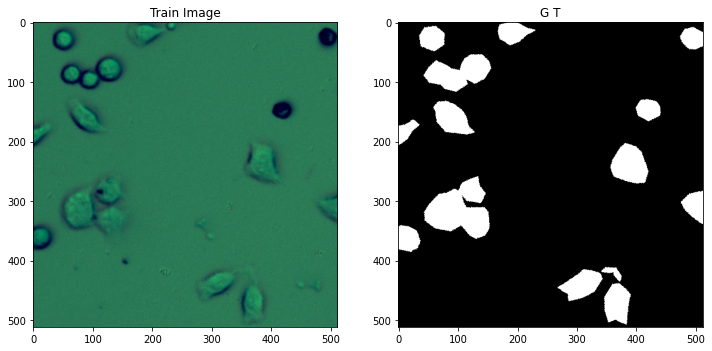

In [5]:
p = image_generator.next()
q = mask_generator.next()
for i in range(0,1):
    image = p[i]
    mask = q[i]
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.title('Train Image')
    #plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.title('G T')
    plt.show()

# Req Parameter to setup

In [ ]:
IMG_HEIGHT = p.shape[1]
IMG_WIDTH  = p.shape[2]
IMG_CHANNELS = p.shape[3]
num_labels = 1  #Binary
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
batch_size = 8

some Metrics for evaliation

In [ ]:

def dice_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)


def jacard_coeficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)


def jacard_coeficient_loss(y_true, y_pred):
    return -jacard_coeficient(y_true, y_pred)


def dice_coeficient_loss(y_true, y_pred):
    return -dice_coeficient(y_true, y_pred)

Useful blocks to build Unet
conv - BN - Activation - conv - BN - Activation - Dropout (if enabled)

In [ ]:
def convolutional_block(x, filter_size, size, dropout, batch_norm=False):
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("LeakyReLU")(conv)

    conv = layers.Conv2D(size, (filter_size, filter_size), padding="same")(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation("LeakyReLU")(conv)
    
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    return conv


Repeating Element

In [ ]:
def repeating_element(tensor, rep):
    # lambda function to repeat the elements of a tensor along an axis
    #by a factor of repitation.
    # If tensor has shape (--, 512,512,3), lambda return a tensor with the shape
    # of shape (--, 512,512,6), if specified axis=3 and repitation=2.

     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

Define Residual Convolutional Block

In [ ]:
def residual_convolutional_block(x, filter_size, size, dropout, batch_norm=False):
    '''
    Residual convolutional layer.
    Two variants....                                 
    '''

    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    conv = layers.Activation('LeakyReLU')(conv)
    
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=3)(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=3)(shortcut)

    res_path = layers.add([shortcut, conv])
    res_path = layers.Activation('LeakyReLU')(res_path)  
    return res_path

Gating Signal Func

In [ ]:
def gating_signal_for_Att(input, out_size, batch_norm=False):

    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

Define ATT Blocks


In [ ]:
def soft_attention_block_str(x, gating, inter_shape):
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

#  x signal will recive the same shape as the gating signal
    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  
    shape_theta_x = K.int_shape(theta_x)

#  gating signal with the same number of filters of the inter_shape
    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g) 

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg) 

    upsample_psi = repeating_element(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

# Simple Unet

In [ ]:
def Simple_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.05, batch_norm=True):
    '''
    UNet, 
    
    '''   
    # required parameters for the network structure
    FILTER_NUM = 64 #  filters number for the first layer
    FILTER_SIZE = 3 # convolutional filter size
    UP_SAMP_SIZE = 2 # upsampling filters size

    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # Downsampling 1, convolution + pooling
    conv_128 = convolutional_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # Downsampling 2
    conv_64 = convolutional_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # Downsampling 3
    conv_32 = convolutional_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # Downsampling 4
    conv_16 = convolutional_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # Downsampling 5, convolution only
    conv_8 = convolutional_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers 
    
    # Upsampleling 6
   
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, conv_16], axis=3)
    up_conv_16 = convolutional_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 7
    
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, conv_32], axis=3)
    up_conv_32 = convolutional_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 8
    
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, conv_64], axis=3)
    up_conv_64 = convolutional_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampleling 9
   
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, conv_128], axis=3)
    up_conv_128 = convolutional_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # convolutional layers (1*1)
   
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  

    # Simple_Unet_Model 
    model = models.Model(inputs, conv_final, name="UNet")
    print(model.summary())
    return model

#Run Normal Unet

In [ ]:
'''
UNet
'''
simple_unet_model = Simple_UNet(input_shape)
simple_unet_model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coeficient])
earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)


print(simple_unet_model.summary())

start1 = datetime.now() 
simple_unet_history = simple_unet_model.fit(training_set_generator, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data= validation_set_generator, steps_per_epoch=100, 
                    validation_steps=100,
                    shuffle=False,
                    epochs=100, callbacks=[earlystop])

stop1 = datetime.now()
#calculate run time of the model 
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

simple_unet_model.save('U_Net_100EP_Correct Dataset_LE-3.hdf5')

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
100/100 [==============================] - 539s 5s/step - loss: 0.1084 - accuracy: 0.8063 - jacard_coef: 8.9881e-04 - val_loss: 3.2646 - val_accuracy: 0.0031 - val_jacard_coef: 5.5234e-04
Epoch 2/100
100/100 [==============================] - 131s 1s/step - loss: 0.0844 - accuracy: 0.8178 - jacard_coef: 9.8579e-04 - val_loss: 0.1058 - val_accuracy: 0.8573 - val_jacard_coef: 5.7204e-04
Epoch 3/100
100/100 [==============================] - 130s 1s/step - loss: 0.0737 - accuracy: 0.8267 - jacard_coef: 9.9237e-04 - val_loss: 0.1034 - val_accuracy: 0.8585 - val_jacard_coef: 5.8306e-04
Epoch 4/100
100/100 [==============================] - 130s 1s/step - loss: 0.0655 - accuracy: 0.8278 - jacard_coef: 0.0010 - val_loss: 0.0971 - val_accuracy: 0.8601 - val_jacard_coef: 6.1555e-04
Epoch 5/100
100/100 [==============================] - 130s 1s/step - loss: 0.0571 - accuracy: 0.8291 - jacard_coef: 0.0011 - val_loss: 0.0604 - val_accuracy: 0.8471 - val_jacard_coef: 8.4844e-04
Epoch 6/

# Soft Attention Unet

In [ ]:
def addetive_sotf_Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.05, batch_norm=True):
    '''
    Attention UNet, 
    
    '''
    # required parameters for the network structure
    FILTER_NUM = 64 #  filters number for the first layer
    FILTER_SIZE = 3 # convolutional filter size
    UP_SAMP_SIZE = 2 # upsampling filters size
    
    inputs = layers.Input(input_shape, dtype=tf.float32)

    # Downsampling layers
    # Downsampling 1, convolution + pooling
    conv_128 = convolutional_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # Downsampling 2
    conv_64 = convolutional_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # Downsampling 3
    conv_32 = convolutional_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # Downsampling 4
    conv_16 = convolutional_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # Downsampling 5, convolution only
    conv_8 = convolutional_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers

    # Upsampling 6,
    gating_16 = gating_signal_for_Att(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = soft_attention_block_str(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=3)
    up_conv_16 = convolutional_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling 7
    gating_32 = gating_signal_for_Att(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = soft_attention_block_str(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=3)
    up_conv_32 = convolutional_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling 8
    gating_64 = gating_signal_for_Att(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = soft_attention_block_str(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=3)
    up_conv_64 = convolutional_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # Upsampling 9
    gating_128 = gating_signal_for_Att(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = soft_attention_block_str(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=3)
    up_conv_128 = convolutional_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # convolutional layers (1*1)
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=3)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final)  

    # Attention Unet Model 
    model = models.Model(inputs, conv_final, name="Attention_UNet")
    return model

# Run Soft Attention U-Net

In [ ]:
'''
Attention UNet
'''
Attention_unet_model = addetive_sotf_Attention_UNet(input_shape)

Attention_unet_model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coeficient, ])

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

print(Attention_unet_model.summary())
start2 = datetime.now() 
Attention_unet_history = Attention_unet_model.fit(training_set_generator, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data= validation_set_generator, steps_per_epoch=100, 
                    validation_steps=100, 
                    shuffle=False,
                    epochs=100, callbacks=[earlystop])
stop2 = datetime.now()
#Calculate time of the model 
execution_time_Att_Unet = stop2-start2
print("Attention UNet execution time is: ", execution_time_Att_Unet)

Attention_unet_model.save('Attention_UNet_100epochs_B_focal_Leakyrelu_Lr-3.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "Attention_UNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#     Rsidual attention Unet 


In [ ]:
def Residual_Attention_UNet(input_shape, NUM_CLASSES=1, dropout_rate=0.0, batch_norm=True):
    '''
    Rsidual UNet, with attention 
    
    '''
    # required parameters for the Residual Attention unet network structure
    FILTER_NUM = 64 #  filters number for the first layer
    FILTER_SIZE = 3 # convolutional filter size
    UP_SAMP_SIZE = 2 # upsampling filters size

    # Input image dimension 
    inputs = layers.Input(input_shape, dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownResidual 1
    conv_128 = residual_convolutional_block(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownResidual 2
    conv_64 = residual_convolutional_block(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownResidual 3
    conv_32 = residual_convolutional_block(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownResidual 4
    conv_16 = residual_convolutional_block(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownResidual 5, convolution only
    conv_8 = residual_convolutional_block(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpResidual 6, 
    gating_16 = gating_signal_for_Att(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = soft_attention_block_str(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = residual_convolutional_block(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpResidual 7
    gating_32 = gating_signal_for_Att(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = soft_attention_block_str(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = residual_convolutional_block(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpResidual 8
    gating_64 = gating_signal_for_Att(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = soft_attention_block_str(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = residual_convolutional_block(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpResidual 9
    gating_128 = gating_signal_for_Att(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = soft_attention_block_str(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = residual_convolutional_block(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    #convolutional layers (1*1)
    
    conv_final = layers.Conv2D(NUM_CLASSES, kernel_size=(1,1))(up_conv_128)
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('sigmoid')(conv_final) 

    # Residual Attention unet Model 
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

# Running Residual Unet

In [ ]:
'''
Residual soft Attention Unet
'''
Residual_Attention_UNet_model = Residual_Attention_UNet(input_shape)

Residual_Attention_UNet_model.compile(optimizer=Adam(lr = 1e-3), loss=BinaryFocalLoss(gamma=2), 
              metrics=['accuracy', jacard_coeficient, 'Recall'])

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 15,
                          verbose = 1,
                          restore_best_weights = True)

print(Residual_Attention_UNet_model.summary())


start3 = datetime.now() 
Residual_Attention_UNet_history = Residual_Attention_UNet_model.fit(training_set_generator, 
                    verbose=1,
                    batch_size = batch_size,
                    validation_data= validation_set_generator, steps_per_epoch=100, 
                    validation_steps=100, 
                    shuffle=False,
                    epochs=150)
stop3 = datetime.now()

#calculate run time of the model 
execution_time_AttResUnet = stop3-start3
print("Attention ResUnet execution time is: ", execution_time_AttResUnet)

Residual_Attention_UNet_model.save('AttResUnet_100epochs_B_focal_LeakyRelu.hdf5')

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "AttentionResUNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                  

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# convert the history.history dict to a pandas DataFrame and save as csv for future plotting

Save Simple Unet History

In [ ]:
import pandas as pd    
simple_unet_history_df = pd.DataFrame(simple_unet_history.history) 
with open('unet_100_Leakyrelu_history_df_LRate10e3.csv', mode='w') as f:
    simple_unet_history_df.to_csv(f)

Save Attention Unet History

In [ ]:
import pandas as pd    
Attention_unet_history_df = pd.DataFrame(Attention_unet_history.history) 
with open('att_Relu_unet_Leaky_history_100EP_df_lr-3.csv', mode='w') as f:
    Attention_unet_history_df.to_csv(f)

Save Residual Attention Unet History

In [ ]:
import pandas as pd    
Residual_Attention_UNet_history_df = pd.DataFrame(Residual_Attention_UNet_history.history) 
with open('custom_code_att_res_unet_history_df.csv', mode='w') as f:
    Residual_Attention_UNet_history_df.to_csv(f) 

#Check history plots, one model at a time

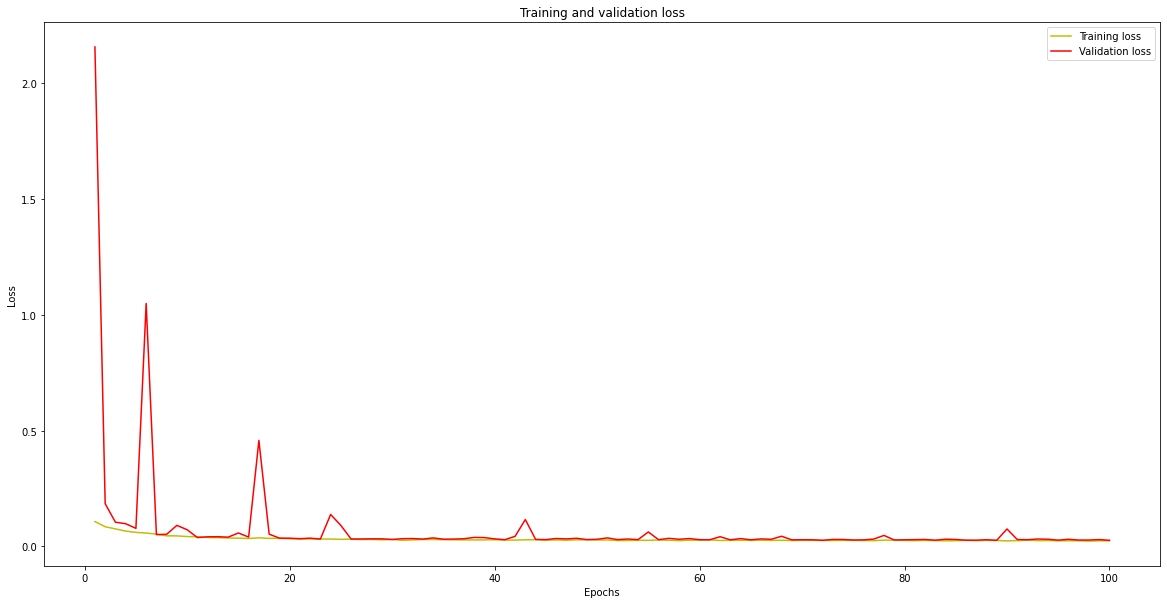

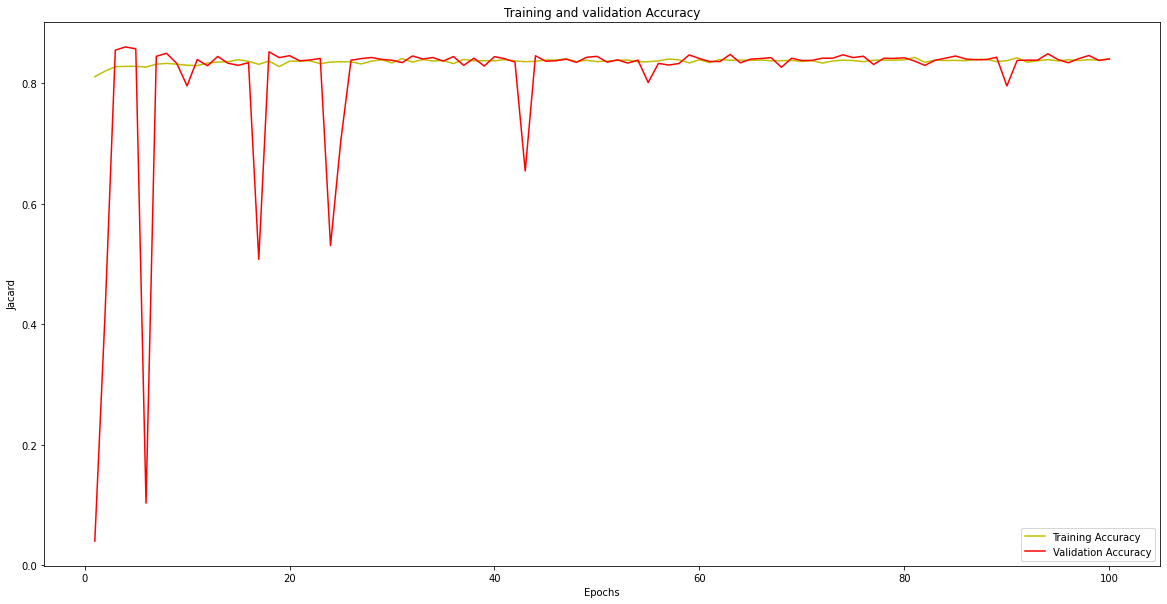

In [ ]:
#history = simple_unet_history
history = Attention_unet_history
#history = Residual_Attention_UNet_history
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig('myimage.tif', format='svg',figsize=(24, 18), dpi=500)

#acc = history.history['jaccard_coef']
acc = history.history['accuracy']
#val_acc = history.history['val_jaccard_coef']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Jaccard')
plt.legend()
plt.show()

#Load Simple U-Net

In [ ]:
Unet_model = tf.keras.models.load_model("/content/drive/MyDrive/Final_Unet_Models/Simple_Unet_Leaky_100Ep_Lr_-3/U_Net_100EP_Correct Dataset_LE-3.hdf5", compile=False)

# Load Res_Att Model

In [6]:
res_Att_model = tf.keras.models.load_model("/content/drive/MyDrive/Final_Unet_Models/Res_Att_Relu_Unet_Leaky_100Ep_Lr_1e-3/AttResUnet_100epochs_B_focal_Relu.hdf5", compile=False)

#Load Att_Model

In [ ]:
att_model = tf.keras.models.load_model("/content/drive/MyDrive/Final_Unet_Models/Att_Relu_Unet_Leaky_Lr_1e-3_100Ep/Attention_UNet_100epochs_B_focal_Leakyrelu_Lr-3.hdf5", compile=False)

##Test the model on images we held out for testing.


In [7]:
test_img_generator = image_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_x_image_test/", 
                                                              seed=seed, 
                                                              batch_size=100, 
                                                              target_size=(512, 512),
                                                              class_mode=None) #Default batch size 32, if not specified here

test_mask_generator = mask_data_generator.flow_from_directory("/content/drive/MyDrive/Colab Notebooks/data/spilit_y_mask_test/", 
                                                              seed=seed, 
                                                              batch_size=100,
                                                              target_size=(512, 512), 
                                                              color_mode = 'grayscale',   #Read masks in grayscale
                                                              class_mode=None)  #Default batch size 32, if not specified here

Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.


#Testing on a few test images

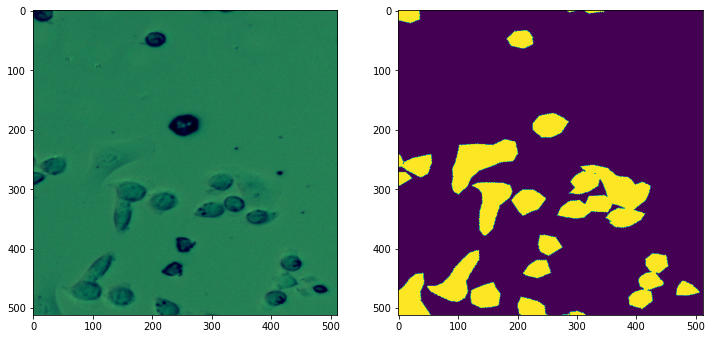

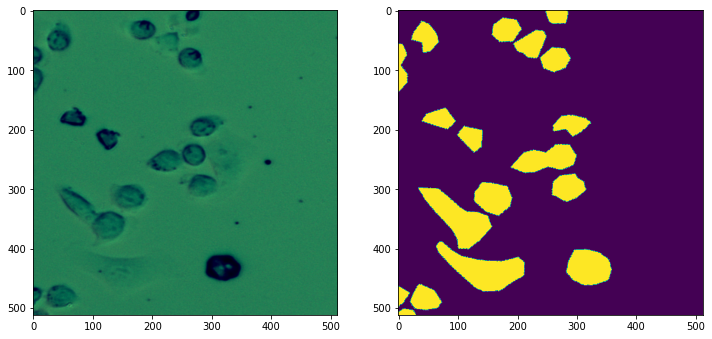

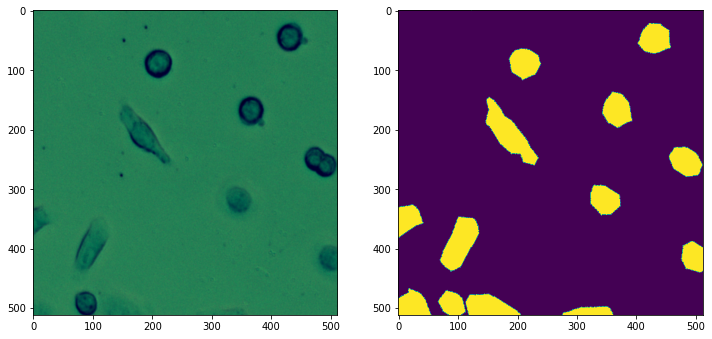

In [8]:
t = test_img_generator.next()
m = test_mask_generator.next()
for i in range(0,3):
    image = t[i]
    mask = m[i]
    plt.figure(figsize=(12, 6))
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

# Testing testset with 3 different unet models


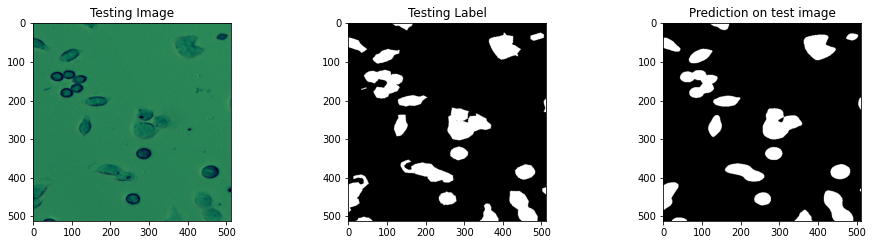

In [10]:
import random
test_img_number = random.randint(0, t.shape[0]-1)
test_img = t[test_img_number]
ground_truth= m[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (res_Att_model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')
plt.show()


# Function of TP, TN, FP, FN

In [18]:
def greytobinary(originalImage):
    
    #im_gray = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
    im_gray = originalImage
    thresh = 0
    blackAndWhiteImage = cv2.threshold(im_gray, thresh, 1, cv2.THRESH_BINARY)[1]
    # (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 127, 255, cv2.THRESH_BINARY)
    
    return blackAndWhiteImage

def Metrics_2(Y_pred,Y_val):
    import seaborn as sns

    FP = len(np.where(Y_pred - Y_val == -1)[0])
    FN = len(np.where(Y_pred - Y_val == 1)[0])
    TP = len(np.where(Y_pred + Y_val == 2)[0])
    TN = len(np.where(Y_pred + Y_val == 0)[0])
    
    Recall = TP/(TP+FN)
    Precision = TP/(TP+FP)
    Accuracy = (TP+TN)/(TP+FN+TN+FP)
    F1 = 2 * (Precision * Recall)/(Precision + Recall)
    IoU =  TP/(TP+FP+FN)
    DICE = (2 * TP) / (2 * TP+FP+FN)
    return Recall,Precision,Accuracy,F1,IoU, TP, TN, FP, FN,DICE


#Calculate Precision, Recall, Accuracy, F1

In [19]:
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import cv2

total_result = pd.DataFrame()
data=[]
from statistics import mean
#IoU_values = []
for img in range(0, t.shape[0]):
  temp_img = t[img]
  ground_truth=m[img]
  temp_img_input=np.expand_dims(temp_img, 0)
  prediction = (res_Att_model.predict(temp_img_input)[0,:,:,0] > 0.55).astype(np.uint8)

  Y_pred = prediction  
  Y_val = greytobinary(ground_truth)
  Y_val = np.reshape(Y_val,(512,512))
  #greytobinary(ground_truth)
  #print(Y_val)
  Y_val = Y_val.astype(int)
  #print(Y_val)
  Y_pred = 1 - Y_pred
  Y_val  = 1 - Y_val

  Recall, Precision, Accuracy, F1, IoU, TP, TN, FP, FN, DICE = Metrics_2(Y_pred,Y_val)
  #print(result.results)
  keys = ['Recall', 'Precision', 'Accuracy', 'F1','IoU', 'TP', 'TN', 'FP', 'FN', 'DICE']
  #keys = ['Recall', 'Precision', 'Accuracy', 'F1','IoU']
  values = [Recall, Precision, Accuracy, F1, IoU, TP, TN, FP, FN, DICE]
  #values = [result.Recall, result.Precision, result.Accuracy, result.F1, result.IoU]

  zipped = zip(keys, values)
  dic = dict(zipped)
  data.append(dic)
  total_result = total_result.append(data, True)

print("\nMean of Recall is: %f\nMean of Precision is: %f"%(mean(total_result['Recall']),mean(total_result['Precision']))) 
print("Mean of Accuracy is: %f\nMean of F1 is: %f\n"%(mean(total_result['Accuracy']),mean(total_result['F1'])))
print("\nMean of IoU is: %f"%(mean(total_result['IoU'])))
print("\nMean of DICE is: %f"%(mean(total_result['DICE'])))



Mean of Recall is: 0.965582
Mean of Precision is: 0.986492
Mean of Accuracy is: 0.959902
Mean of F1 is: 0.975836


Mean of IoU is: 0.953077

Mean of DICE is: 0.975836


#Visual Bar

In [ ]:
from google.colab import output
#I don't know why nbextensions don't work with python3.6 
with output.temporary():
  !pip install --upgrade git+https://github.com/Kreijstal/colab_inspector.git 
  !python2.7 -m pip install --upgrade git+https://github.com/blois/colab_inspector.git #yes, really.
  !jupyter nbextension install --py inspector

import inspector

# open a scratch cell (Ctrl+Alt+N)
# run there


In [ ]:
# inspector.watch_globals()
inspector.watch_globals()

#Save segmented image sample

In [ ]:
plt.imsave('/content/drive/MyDrive/Colab Notebooks/output3.png', prediction, cmap = 'binary')
plt.imsave('/content/drive/MyDrive/Colab Notebooks/ground3.png', ground_truth[:,:,0], cmap = 'binary')
plt.imsave('/content/drive/MyDrive/Colab Notebooks/test3.png', test_img)

#Watershed method for instance Segmentation


In [ ]:
import numpy as np
import cv2
import pandas as pd
import glob
import pickle
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import measure, color, io
import os
import pandas as pd
from skimage import data, io
from skimage import data, io

#####Watershed 
def process_images(prediction):
  #img = cv2.imread("/content/drive/MyDrive/Colab Notebooks/output3.png")  #Read as color (3 channels)
  img_grey = prediction
  #img_grey = prediction[:,:,0]
  
# change the unet result to binary image
# Threshold image to binary using OTSU. All thresholded pixels will be set to 255
  ret1, thresh = cv2.threshold(img_grey, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

#plt.imshow(thresh, cmap = 'gray')
# Morphological operations to remove small noise - opening
# To remove holes we can use closing
  kernel = np.ones((3,3),np.uint8)
  opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
#plt.imshow(opening, cmap = 'gray')

#Watershed should find this area (Sure_Background) for us. 
  sure_bg = cv2.dilate(opening,kernel,iterations=10)
  #plt.imshow(sure_bg, cmap = 'gray')

# extract sure foreground area using distance transform and thresholding
  dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)

# threshold the dist transform by starting at 1/2 its max value.
  ret2, sure_fg = cv2.threshold(dist_transform, 0.48 *dist_transform.max(),255,0)

# Unknown  region will calculate according to bkground - foreground
  sure_fg = np.uint8(sure_fg)
  unknown = cv2.subtract(sure_bg,sure_fg)


# For sure regions,  foreground and background will be consider and kabel with positive numbers.
# Unknown regions will be labeled 0. 
  ret3, markers = cv2.connectedComponents(sure_fg)

# add 10 to all labels so that sure background will be consider as 10
  markers = markers+10

# Now, mark the region of unknown with zero
  markers[unknown==255] = 0
  prediction = cv2.cvtColor(prediction, cv2.COLOR_GRAY2BGR)
#plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.
 
  markers = cv2.watershed(prediction, markers)
  #plt.imshow(markers, cmap='gray')

#boundary region will be marked -1
#color boundaries in yellow. 
  prediction[markers == -1] = [0,255,255]  

  processed = color.label2rgb(markers, bg_label=0)

  props = measure.regionprops_table(markers, intensity_image=img_grey, 
                              properties=['label',
                                          'area', 'equivalent_diameter',
                                          'mean_intensity', 'solidity'])
    
  df = pd.DataFrame(props)
  df = df[df.mean_intensity > 100]  
  #print(dataf.head())
  return df, processed

#Watershed Segmentation Step

,label,area,equivalent_diameter,mean_intensity,solidity


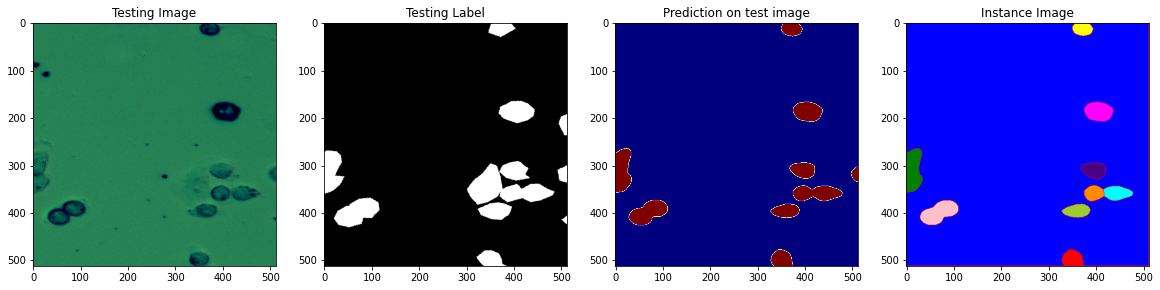

In [ ]:
import random
measurment = pd.DataFrame([])
test_img_number = random.randint(0, t.shape[0]-1)
test_img = t[test_img_number]
ground_truth= m[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
# prediction = prediction
prediction = (Unet_model.predict(test_img_input)[0,:,:,0] > 0.60).astype(np.uint8)
result_table, processed_img = process_images(prediction)
measurment = measurment.append(result_table)
org_1 = test_img
display (measurment)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,4,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,4,3)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,4,4)
plt.title('Instance Image')
plt.imshow(processed_img, cmap='jet')
plt.show()

#Repeat Watershed to find Best Trheshold

,label,area,equivalent_diameter,mean_intensity,solidity


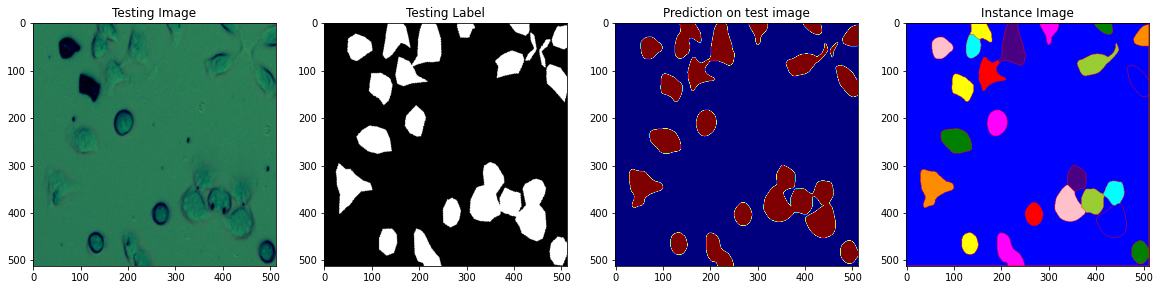

In [ ]:
prediction = (Unet_model.predict(test_img_input)[0,:,:,0] > 0.57).astype(np.uint8)
result_table, processed_img = process_images(prediction)
measurment = measurment.append(result_table)
display (measurment)
plt.figure(figsize=(20, 8))
plt.subplot(1,4,1)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,4,2)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,4,3)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,4,4)
plt.title('Instance Image')
plt.imshow(processed_img, cmap='jet')
plt.show()

# Visalizing Segmentation Result

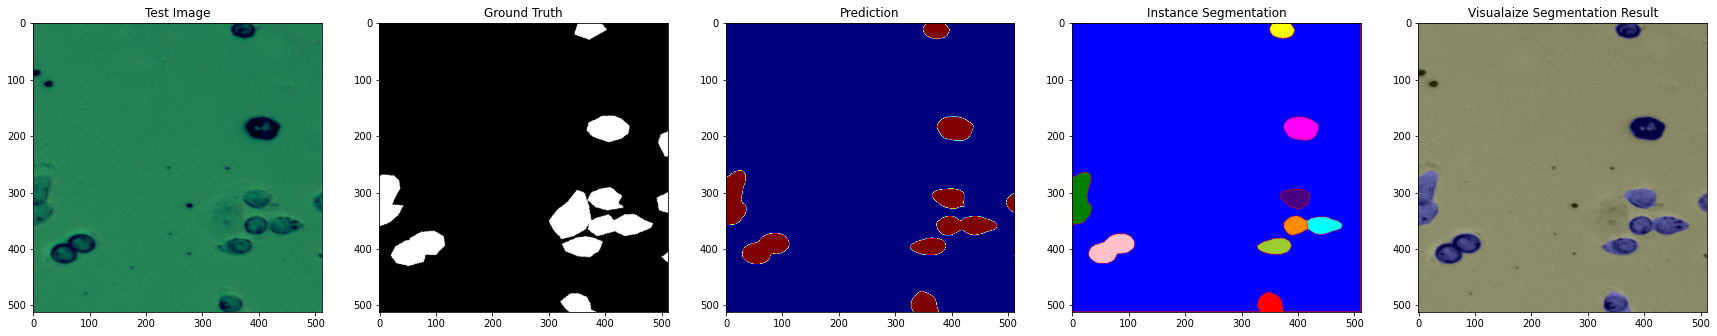

In [ ]:
import random
import cv2
import glob
import os
import math
import numpy as np
import cv2
import pandas as pd
import pandas as pd
from skimage import io, color
import matplotlib.pyplot as plt
#main_color = cv2.imread(org_img_dir,cv2.IMREAD_COLOR)
# io.imshow(color.label2rgb(seg_visual,main,colors=[(255,0,0),(0,0,255)],alpha=0.01, bg_label=0, bg_color=None))
prediction = (Unet_model.predict(test_img_input)[0,:,:,0] > 0.55).astype(np.uint8)
seg_visual = np.zeros((512,512)) # create a matrix of zeroes of same size as image
# Load images as greyscale but make main RGB so we can annotate in colour
seg = prediction
seg_visual[seg == 1] = 1   # Change zeroes to label "1" as per your condition(s)
seg_visual[seg == 0] = 2  


test_img2 = test_img
main_color = test_img
#main = cv2.cvtColor(main,cv2.COLOR_GRAY2BGR)

#io.imshow(color.label2rgb(seg_visual,main_color,colors=[(255,0,0),(0,0,255)],alpha=0.1, bg_label=0, bg_color=None))
#plt.show()
#result = io.imshow(color.label2rgb(seg_visual,main_color,colors=[(255,0,0),(0,0,255)],alpha=0.001, bg_label=0, bg_color=None))
plt.imsave('seg_res_2.png', color.label2rgb(seg_visual, main_color,colors=[(255,0,0),(0,128,128)],alpha=0.001, bg_label=0, bg_color=None), cmap = plt.cm.gray)
result = cv2.imread('seg_res_2.png')

#plt.show()

plt.figure(figsize=(30, 8))
plt.subplot(1,5,1)
plt.title('Test Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(1,5,2)
plt.title('Ground Truth')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(1,5,3) 
plt.title('Prediction')
plt.imshow(prediction, cmap='jet')
plt.subplot(1,5,4)
plt.title('Instance Segmentation')
plt.imshow(processed_img, cmap='jet')
#plt.show()
plt.subplot(1,5,5)
plt.title('Visualaize Segmentation Result')
plt.imshow(result)
plt.show()


#Plot Validation Loss from History.csv

In [ ]:
os.chdir("/content/drive/MyDrive/Final_Unet_Models/Simple_Unet_Leaky_100Ep_Lr_-3/")
csv_file = glob.glob('*.csv')
History1 = pd.DataFrame()
History1 = pd.read_csv ('unet_100_Leakyrelu_history_df_LRate10e3.csv', sep=",", header=0)
History1 = History1[1:99]


In [ ]:
os.chdir("/content/drive/MyDrive/Final_Unet_Models/Att_Relu_Unet_Leaky_Lr_1e-3_100Ep/")
csv_file = glob.glob('*.csv')
History2 = pd.DataFrame()
History2 = pd.read_csv ('att_Relu_unet_Leaky_history_100EP_df_lr-3.csv', sep=",", header=0)
History2 = History2[1:99]

In [ ]:
os.chdir("/content/drive/MyDrive/Final_Unet_Models/Res_Att_Relu_Unet_Leaky_100Ep_Lr_1e-3/")
csv_file = glob.glob('*.csv')
History3 = pd.DataFrame()
History3 = pd.read_csv ('res_att_relu_unet_Leaky_history_df.csv', sep=",", header=0)
History3 = History3[1:99]

#Plot simple unet

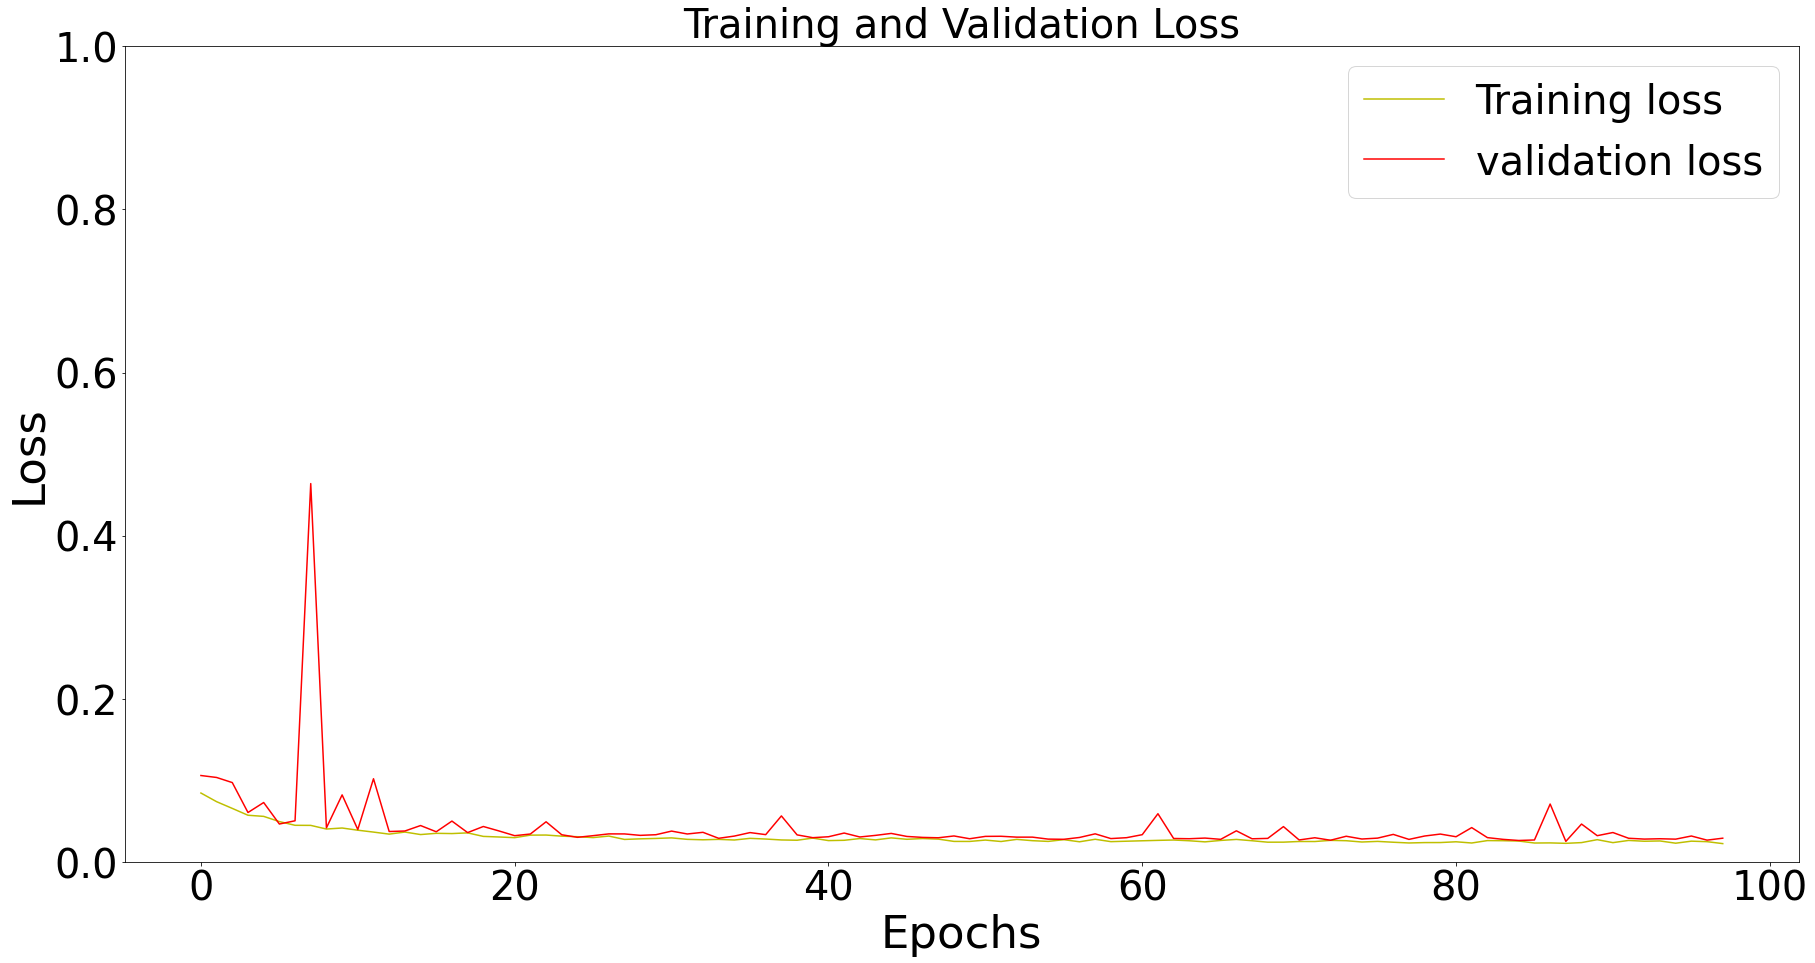

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
loss_train = History1['loss']
loss_val = History1['val_loss']
epochs = range(0, len(History1))

SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 1)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Simple_Unet', format='png',figsize=(8, 4), dpi=250)
plt.show()

#Plot ATT-Unet

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
loss_train = History2['loss']
loss_val = History2['val_loss']
#epochs = range(1, len(History2)+1)

SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 1.08)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Attention_Unet', format='png',figsize=(8, 4), dpi=250)
plt.show()

NameError: ignored

#Plot Res ATT 

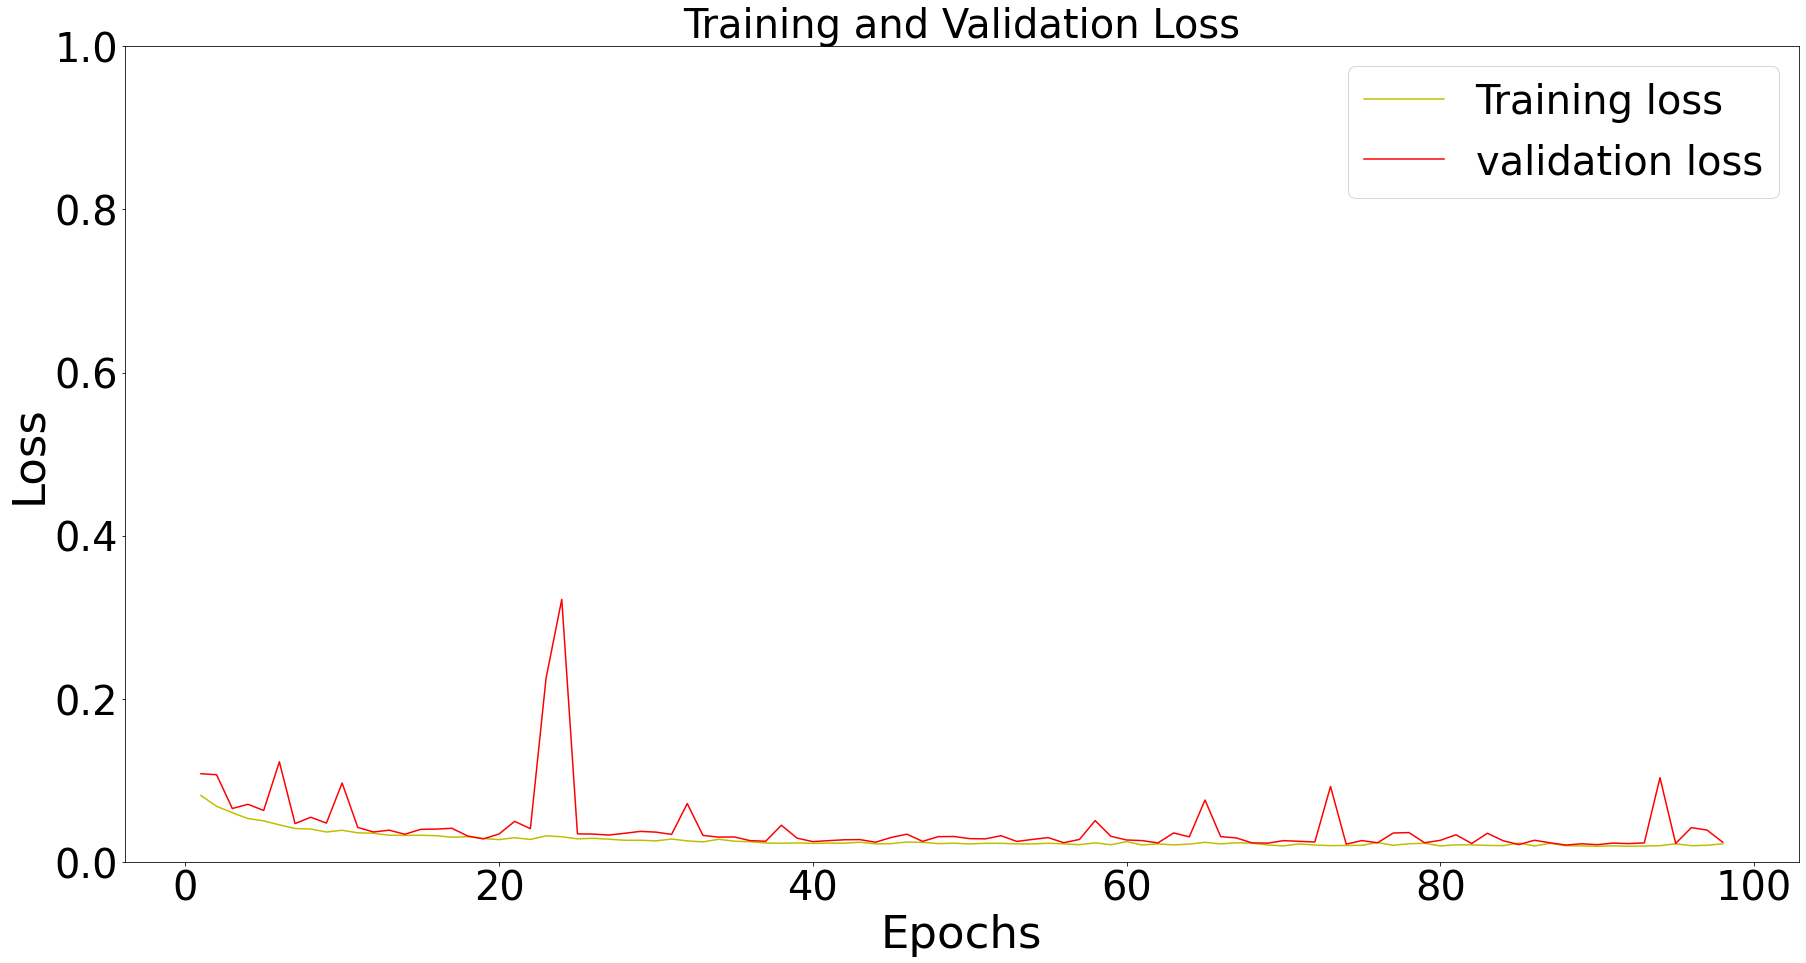

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)

loss_train = History3['loss']
loss_val = History3['val_loss']
epochs = range(1, len(History3)+1)

SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 1)
plt.plot(epochs, loss_train, 'y', label='Training loss')
plt.plot(epochs, loss_val, 'r', label='validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Residual_Attention_Unet', format='png',figsize=(8, 4), dpi=250)
plt.show()

#Plot Simple Unet_Jaccard

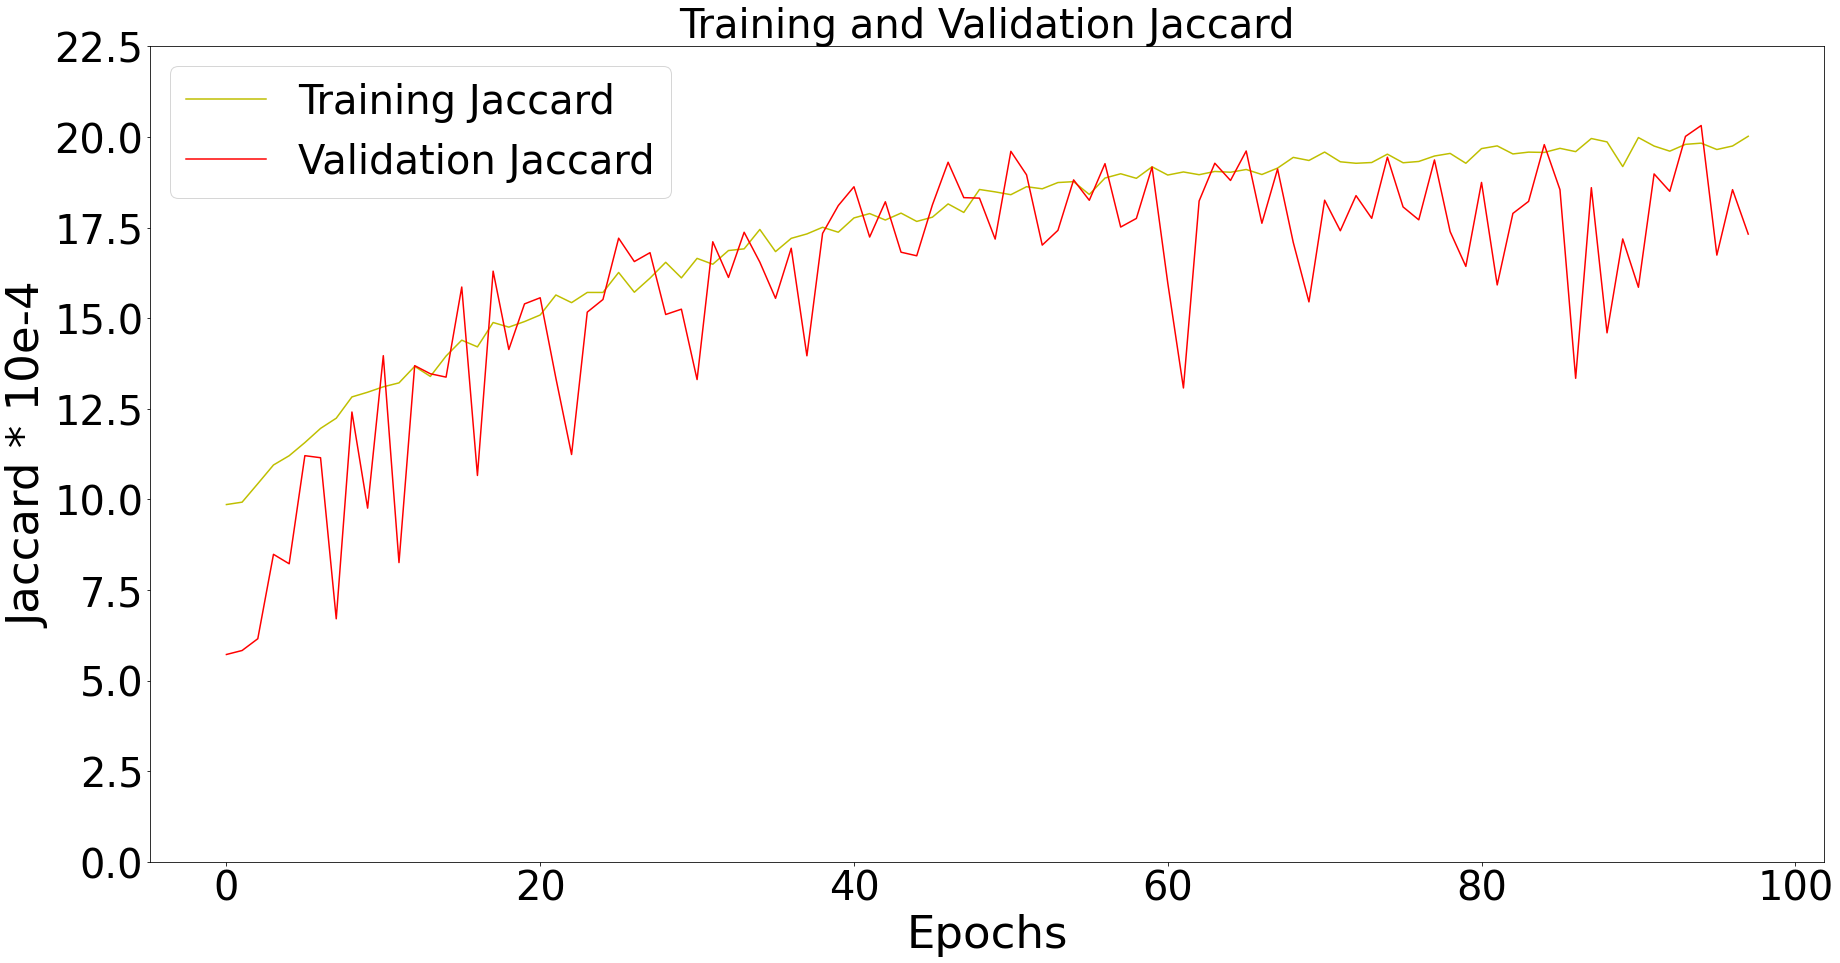

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
acc = History1['jacard_coef']*10000
#acc = history.history['accuracy']
val_acc = History1['val_jacard_coef']*10000
#val_acc = history.history['val_accuracy']
SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 22.5)
plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard * 10e-4')
plt.legend()
plt.savefig('Simple_Unet_Jaccard', format='png',figsize=(8, 4), dpi=250)
plt.show()

#Plot ATT_Unet_Jaccard

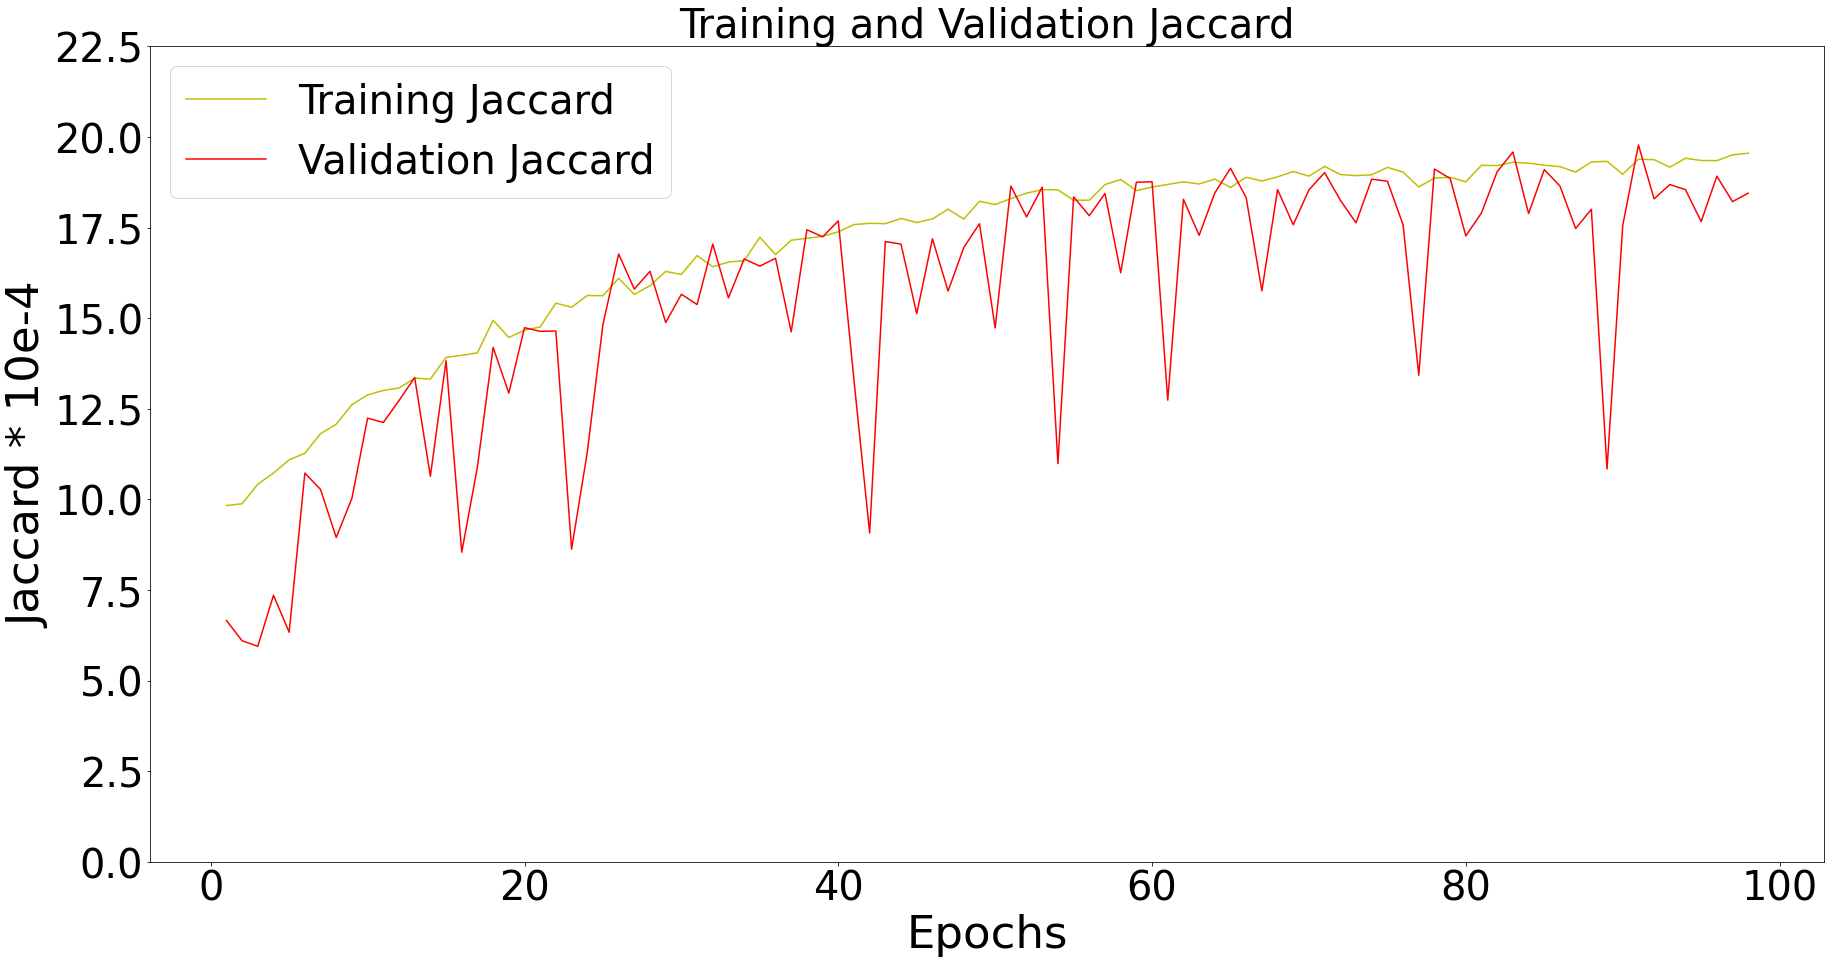

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
acc = History2['jacard_coef']*10000
#acc = history.history['accuracy']
val_acc = History2['val_jacard_coef']*10000
#val_acc = history.history['val_accuracy']
SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 22.5)
plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard * 10e-4')
plt.legend()
plt.savefig('Att_Unet_Jaccard', format='png',figsize=(8, 4), dpi=250)
plt.show()

#Plot Res_ATt_Unet_Jaccard

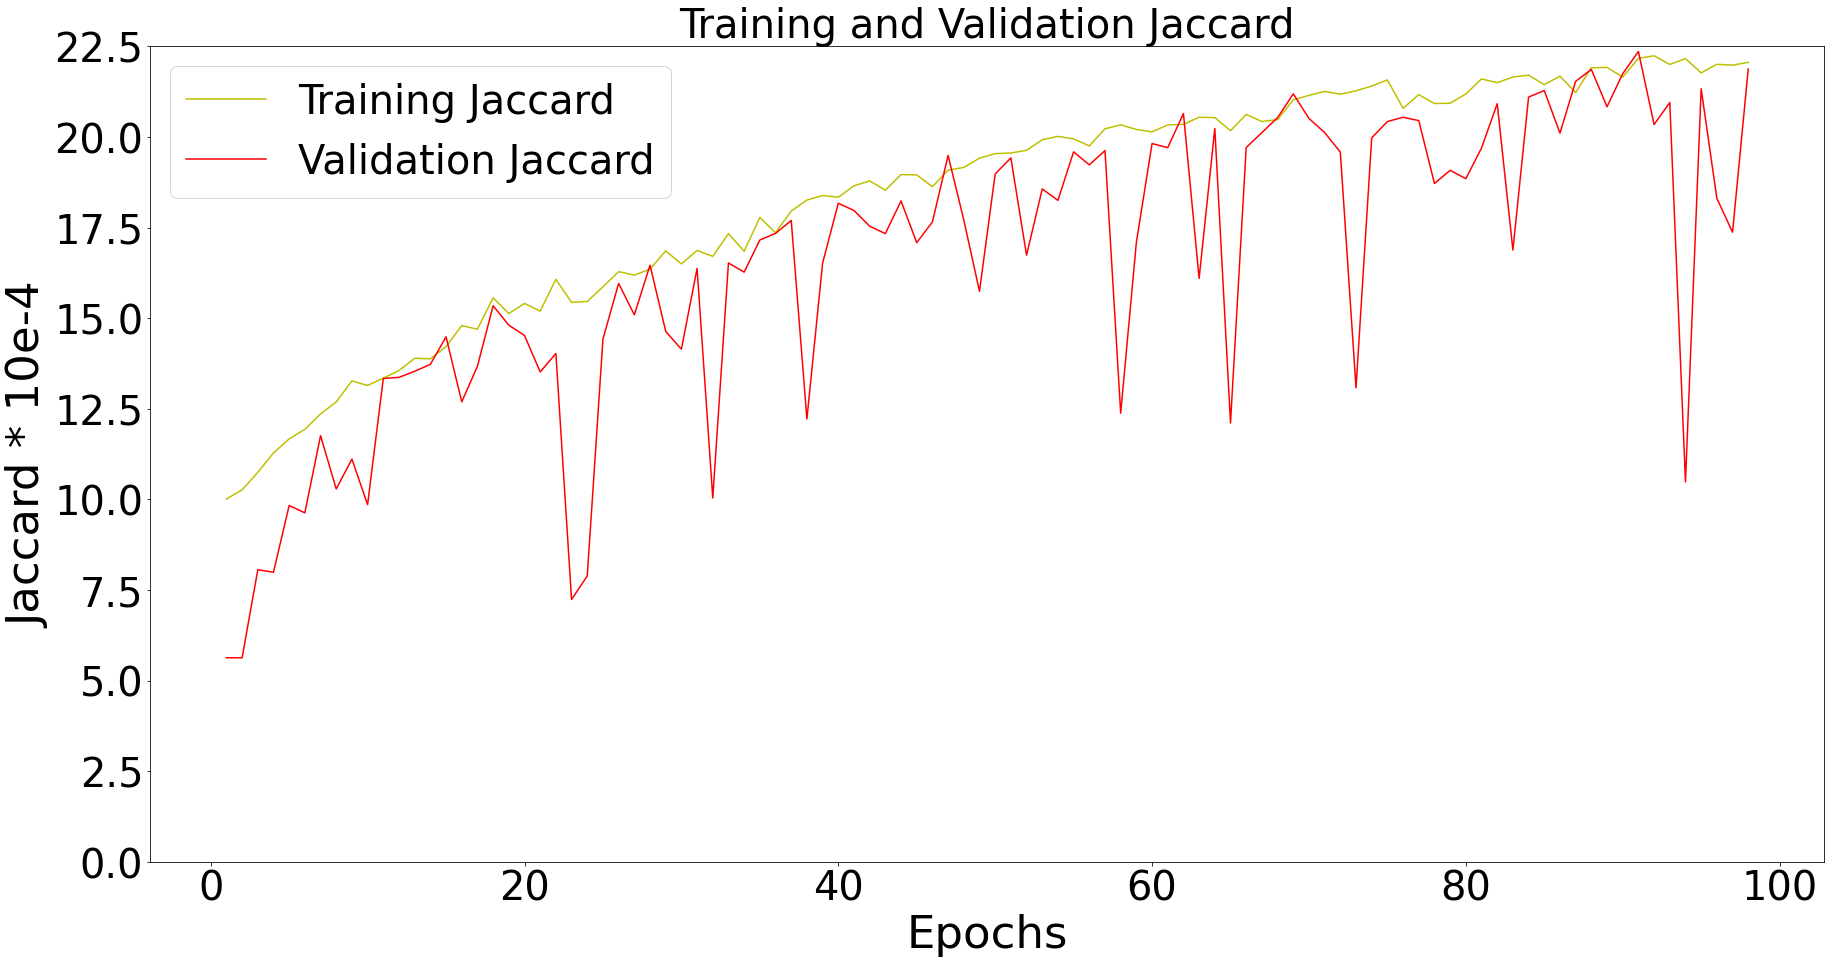

In [ ]:
plt.rcParams["figure.figsize"] = (30,15)
acc = History3['jacard_coef']*10000
#acc = history.history['accuracy']
val_acc = History3['val_jacard_coef']*10000
#val_acc = history.history['val_accuracy']
SMALL_SIZE = 40
MEDIUM_SIZE = 45
BIGGER_SIZE = 50

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.ylim(0 , 22.5)
plt.plot(epochs, acc, 'y', label='Training Jaccard')
plt.plot(epochs, val_acc, 'r', label='Validation Jaccard')
plt.title('Training and Validation Jaccard')
plt.xlabel('Epochs')
plt.ylabel('Jaccard * 10e-4')
plt.legend()
plt.savefig('Res_Att_Unet_Jaccard', format='png',figsize=(8, 4), dpi=250)
plt.show()